# Przykładowy kod rozwiązania zadania konkursowego

## Pobranie i rozpakowanie danych

In [ ]:
! wget https://skn-rtg.s3.amazonaws.com/train.zip

lub pobierz dane samodzielnie/wykorzystując odpowiednie zależności z google drive

### Rozpakowanie danych

In [3]:
!unzip -q train.zip

## Zaimportowanie zależności

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scikitplot as skplt

## Przykładowe wykorzystanie

In [2]:
target_size = (160,160)

In [3]:
! ls train | grep csv

labels.csv


In [4]:
data_df = pd.read_csv('train/labels.csv',header = None, names = ['filename','class'])
data_df = data_df.sort_values('class')

In [5]:
data_df.head()

,filename,class
0,00001.jpg,0
48652,48653.jpg,0
48653,48654.jpg,0
48654,48655.jpg,0
48655,48656.jpg,0


In [6]:
data_df.tail()

,filename,class
23192,23193.jpg,1
58072,58073.jpg,1
6766,06767.jpg,1
41583,41584.jpg,1
40824,40825.jpg,1


In [7]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = lambda x: x/255,
    rotation_range=5, 
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    shear_range=0.05, 
    zoom_range=0.05, 
    horizontal_flip=True, 
    vertical_flip=True)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = lambda x: x/255)

In [8]:
mask = np.random.rand(len(data_df)) < 0.8
train_df = data_df[mask]
val_df = data_df[~mask]

In [9]:
print('% of positive in training DS = {}'.format(np.sum(train_df['class'].values==1)/len(train_df)))
print('% of positive in validation DS = {}'.format(np.sum(val_df['class'].values==1)/len(val_df)))

% of positive in training DS = 0.0999113905003929
% of positive in validation DS = 0.1003499042714729


In [10]:
train_gen = train_gen.flow_from_dataframe(train_df, directory = 'train', class_mode = 'other', target_size=target_size, batch_size = 32)
val_gen = val_gen.flow_from_dataframe(val_df, directory = 'train', class_mode = 'other', target_size=target_size, batch_size = 128, shuffle=False)

Found 59813 images.
Found 15147 images.


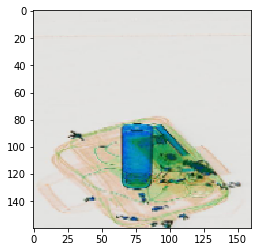

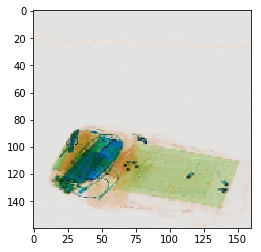

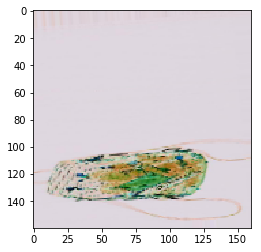

In [11]:
for i in train_gen[0][0][:3]:
    plt.imshow(np.squeeze(i))
    plt.show()

In [12]:
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(*target_size, 3), weights=None, classes = 2, dropout=1e-1)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [14]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(sgd, 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
checkpt = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_df['class'].values),
                                                 train_df['class'].values)

In [18]:
model.fit_generator(train_gen, validation_data = val_gen, callbacks = [checkpt],
                    steps_per_epoch = 500, epochs = 5, verbose = 1, workers=6,
                    class_weight=class_weights)

Epoch 1/5
500/500 [==============================] - 148s 297ms/step - loss: 0.2578 - acc: 0.9146 - val_loss: 0.3960 - val_acc: 0.8997
Epoch 2/5
500/500 [==============================] - 145s 290ms/step - loss: 0.2241 - acc: 0.9289 - val_loss: 0.4093 - val_acc: 0.8116
Epoch 3/5
500/500 [==============================] - 146s 292ms/step - loss: 0.1994 - acc: 0.9369 - val_loss: 0.2867 - val_acc: 0.9212
Epoch 4/5
500/500 [==============================] - 148s 295ms/step - loss: 0.2012 - acc: 0.9347 - val_loss: 0.2550 - val_acc: 0.9061
Epoch 5/5
500/500 [==============================] - 150s 300ms/step - loss: 0.1923 - acc: 0.9371 - val_loss: 0.2096 - val_acc: 0.9366


In [19]:
model.load_weights('model.h5')

In [20]:
y_pred = model.predict_generator(val_gen)

In [21]:
print('acc = {}'.format(100*(np.sum(np.argmax(y_pred,axis=1)==val_df['class'].values)/len(val_df))))

acc = 93.66211130917014


In [22]:
metrics.confusion_matrix(val_df['class'].values, np.argmax(y_pred, axis=1))

array([[13562,    65],
       [  895,   625]])

In [23]:
print(metrics.classification_report(val_df['class'].values, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13627
           1       0.91      0.41      0.57      1520

   micro avg       0.94      0.94      0.94     15147
   macro avg       0.92      0.70      0.77     15147
weighted avg       0.93      0.94      0.93     15147



In [24]:
metrics.roc_auc_score(val_df['class'].values, y_pred[:,1])

0.8602363535241567

/home/szymon/miniconda3/envs/skn/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


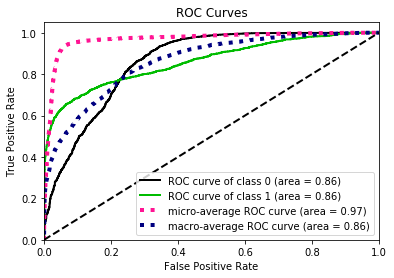

In [25]:
skplt.metrics.plot_roc_curve(val_df['class'].values, y_pred)